# Exploratory Data Analysis: Spatiotemporal Matrix

This notebook is set up for exploring the preprocessed spatiotemporal matrix dataset.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt

# Configuration (Must match 3_data_merging.ipynb)
GLOBAL_START_TIME = "2025-06-06 00:00:00"
TIME_BIN_SIZE_MIN = 5 # Reverted to 5 minutes for stability
DISTANCE_BIN_COUNT = 64 # Updated to match Paper

# File Paths
MATRIX_PATH = "../data/headway_matrix_bidirectional.npy" # Updated to new file
STATION_PATH = "../data/a_line_station_distances.csv"

## 1. Load Data and Reconstruct Metadata

In [2]:
# Load raw matrix
data = np.load(MATRIX_PATH)
print(f"Matrix Shape: {data.shape}")
# Expected: (Time, 64, 2)

# Load station map for spatial context
station_map = pd.read_csv(STATION_PATH)

# --- Reconstruct Time Coordinates ---
time_coords = pd.date_range(
    start=GLOBAL_START_TIME, 
    periods=data.shape[0], 
    freq=f'{TIME_BIN_SIZE_MIN}min'
)

# --- Reconstruct Space Coordinates ---
min_dist = station_map['distance_from_start_mi'].min()
max_dist = station_map['distance_from_start_mi'].max()
space_coords = np.linspace(min_dist, max_dist, data.shape[1])

# --- Create Xarray DataArray ---
# Now 3D: Time, Space, Direction
da = xr.DataArray(
    data,
    dims=["time", "space", "direction"],
    coords={
        "time": time_coords,
        "space": space_coords,
        "direction": ["North", "South"]
    },
    attrs={
        "units": "minutes",
        "description": "Interpolated Headway"
    },
    name="headway"
)

da

Matrix Shape: (264190, 64, 2)


<xarray.DataArray 'headway' (time: 264190, space: 64, direction: 2)> Size: 271MB
array([[[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  1.41666667],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  1.41666667],
        ...,
...
        ...,
        [ 8.8       ,  0.        ],
        [ 8.8       ,  0.        ],
        [ 8.8       ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        , 16.71666667],
        ...,
        [ 8.8       ,  0.        ],
        [ 8.8       ,  0.        ],
        [ 8.8       ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        , 16.        ],
        ...,
        [ 8.8       ,  0.        ],
        [ 8.8       ,  0.        ],
        [ 8.8       ,  0.        ]]], shape=(264190, 64, 2))
Coordinates:
  * time       (time) datetime64[ns] 2MB 2025-06-06 ... 2027-12-10T07:45:00
  * space      (space) float64 512B 9.467 9.827 10.19 10.55 ... 31.48 31.84 32.2
  * direction  (direction) <U5 40B 'North' 'South'
Attributes:
    units:        minutes
    description:  Interpolated Headway

## 2. Visualizations

--- Plot Coverage (Northbound) ---
Time Range: 2025-06-06T00:00:00.000000000 to 2025-06-13T23:55:00.000000000
Space Range (Miles): 9.47 to 32.20
Total Time Bins: 2304
Total Space Bins: 64


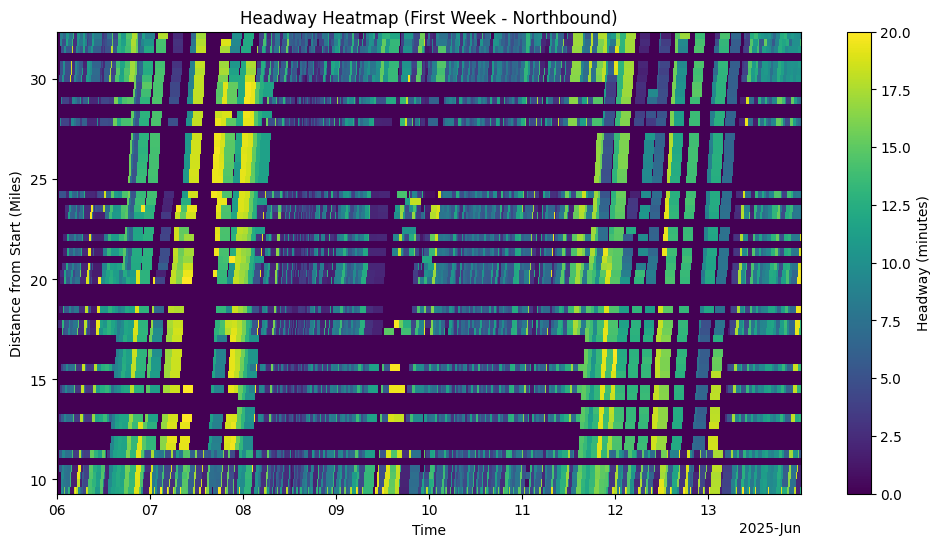

In [3]:
# Select the subset for the first week
# We select Northbound (direction=0) for visualization to verify clean flow
subset = da.sel(time=slice("2025-06-06", "2025-06-13")).isel(direction=0)

# Print coordinate ranges to confirm coverage
print("--- Plot Coverage (Northbound) ---")
print(f"Time Range: {subset.time.min().values} to {subset.time.max().values}")
print(f"Space Range (Miles): {subset.space.min().values:.2f} to {subset.space.max().values:.2f}")
print(f"Total Time Bins: {subset.sizes['time']}")
print(f"Total Space Bins: {subset.sizes['space']}")

# Plot with explicit labels
subset.plot(
    x="time", 
    y="space", 
    figsize=(12, 6),
    cbar_kwargs={'label': 'Headway (minutes)'}
)

plt.title("Headway Heatmap (First Week - Northbound)")
plt.ylabel("Distance from Start (Miles)")
plt.xlabel("Time")
plt.show()

In [4]:
# Check for variance to ensure data is not static
std_dev = da.std(dim="time").mean().values
print(f"Average Standard Deviation: {std_dev}")

Average Standard Deviation: 4.323202296497864


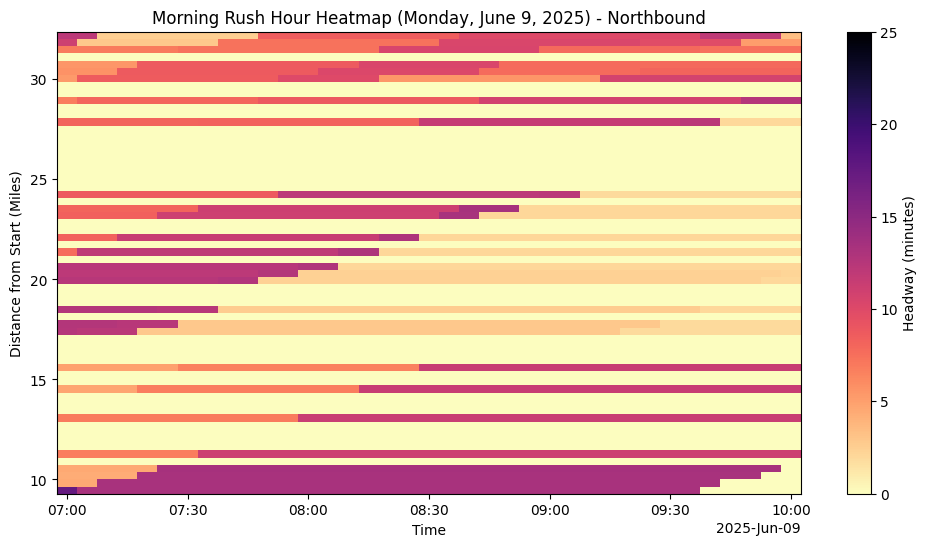

In [5]:
# Select a specific weekday rush hour (e.g., Monday Morning, June 9th, 7 AM - 10 AM)
# This allows us to see the fine-grained texture of headways during peak operations
# Selecting Northbound
rush_hour_subset = da.sel(time=slice("2025-06-09 07:00:00", "2025-06-09 10:00:00")).isel(direction=0)

plt.figure(figsize=(12, 6))
rush_hour_subset.plot(
    x="time",
    y="space",
    cbar_kwargs={'label': 'Headway (minutes)'},
    cmap="magma_r",  # 'magma_r' (reversed) makes low headways (good) dark/purple and high headways (gaps) bright/yellow
    vmax=25          # Cap visualization at 25 mins to highlight gaps without washing out the plot
)

plt.title("Morning Rush Hour Heatmap (Monday, June 9, 2025) - Northbound")
plt.ylabel("Distance from Start (Miles)")
plt.xlabel("Time")
plt.show()

## 3. Data Representation for ConvLSTM

Following the experiment plan (Section 1.1), we need to transform our 3D Matrix into 5D Tensors for the Deep Learning model.

**The Tuple $(X, T, Y)$:**
*   **Input $X$ (Context):** Recent history of the heatmap. Shape: `(Batch, Lookback, Space, Direction, 1)`
*   **Input $T$ (Intent):** Scheduled terminal headways (Dispatcher intent). Shape: `(Batch, Forecast, Direction, 1)`
*   **Target $Y$ (Ground Truth):** Future heatmap. Shape: `(Batch, Forecast, Space, Direction, 1)`


Filling 50 NaNs in scheduled_headway_min...
Aligned Schedule Shape: (264190,)
Matrix Shape: (264190, 64, 2)
Schedule Index Levels: 1


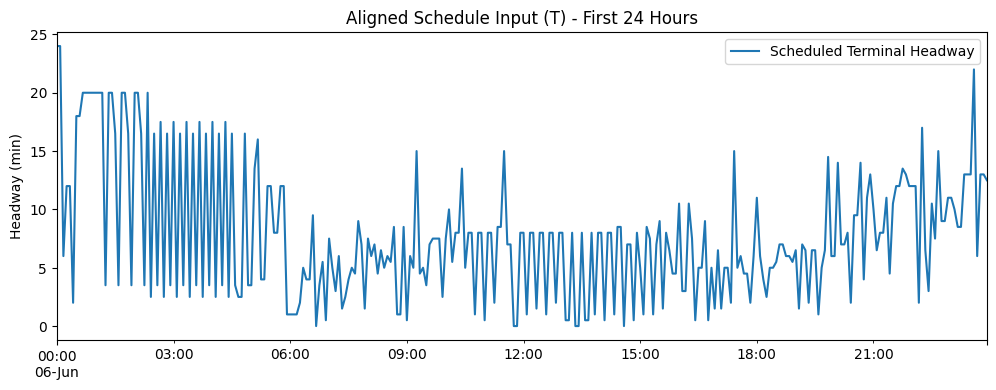

In [ ]:
# --- 1. Load and Align Schedule Data (T) ---
SCHEDULE_PATH = "../data/target_terminal_headways.csv"

# Load Schedule
schedule_df = pd.read_csv(SCHEDULE_PATH)

# Use departure_seconds to handle GTFS times that go past 24:00:00 (e.g., 25:30:00)
schedule_df['datetime'] = pd.to_datetime(schedule_df['service_date']) + pd.to_timedelta(schedule_df['departure_seconds'], unit='s')

schedule_df = schedule_df.set_index('datetime').sort_index()

# --- FIX: Remove duplicate timestamps ---
schedule_df = schedule_df[~schedule_df.index.duplicated(keep='first')]

# Filter to match Matrix timeframe
schedule_df = schedule_df[schedule_df.index >= GLOBAL_START_TIME]

# --- FIX: Handle NaNs in Schedule ---
# Check for NaNs and fill them to prevent gaps in the plot
if schedule_df['scheduled_headway_min'].isna().any():
    print(f"Filling {schedule_df['scheduled_headway_min'].isna().sum()} NaNs in scheduled_headway_min...")
    schedule_df['scheduled_headway_min'] = schedule_df['scheduled_headway_min'].ffill().bfill()

# Resample to bin size
# We use ffill to propagate the last known scheduled headway
schedule_resampled = schedule_df['scheduled_headway_min'].resample(f'{TIME_BIN_SIZE_MIN}min').ffill()

# Align with Matrix Time Coords
schedule_aligned = schedule_resampled.reindex(time_coords, method='ffill').bfill().fillna(0)

print(f"Aligned Schedule Shape: {schedule_aligned.shape}")
print(f"Matrix Shape: {da.shape}")

# Visualize alignment
plt.figure(figsize=(12, 4))
schedule_aligned.iloc[:288].plot(label="Scheduled Terminal Headway") # First 24 hours
plt.title("Aligned Schedule Input (T) - First 24 Hours")
plt.ylabel("Headway (min)")
plt.legend()
plt.show()

In [7]:
# --- 2. Define Sliding Window Generator ---

def create_dataset(matrix, schedule, lookback_bins, forecast_bins):
    """
    Creates (X, T, Y) tensors for ConvLSTM.
    
    Args:
        matrix: 3D numpy array (Time, Space, Direction)
        schedule: 1D numpy array (Time,)
        lookback_bins: Number of past steps (L)
        forecast_bins: Number of future steps (F)
        
    Returns:
        X: (Batch, L, Space, Direction, 1)
        T: (Batch, F, Direction, 1)
        Y: (Batch, F, Space, Direction, 1)
    """
    X, T, Y = [], [], []
    
    # Loop through time
    # We need enough history (L) and enough future (F)
    for i in range(lookback_bins, len(matrix) - forecast_bins):
        # Input X: Past L steps
        # Shape: (L, Space, Direction)
        x_window = matrix[i-lookback_bins:i, :, :]
        X.append(x_window)
        
        # Input T: Future F steps (Dispatcher Intent)
        # Schedule is 1D, we duplicate for both directions
        t_window = schedule[i:i+forecast_bins]
        t_window_2d = np.stack([t_window, t_window], axis=1) # (F, 2)
        T.append(t_window_2d)
        
        # Target Y: Future F steps (Ground Truth)
        y_window = matrix[i:i+forecast_bins, :, :]
        Y.append(y_window)
        
    # Convert to numpy arrays and add channel dimension
    X = np.array(X)[..., np.newaxis] # (Batch, L, Space, Direction, 1)
    T = np.array(T)[..., np.newaxis] # (Batch, F, Direction, 1)
    Y = np.array(Y)[..., np.newaxis] # (Batch, F, Space, Direction, 1)
    
    return X, T, Y

In [8]:
# --- 3. Generate Sample Batch ---
# Parameters from Experiment Plan (Exp-A1)
L_MINS = 30 # Updated to 30
F_MINS = 15 # Updated to 15

L_BINS = L_MINS // TIME_BIN_SIZE_MIN  # 30 / 1 = 30 bins
F_BINS = F_MINS // TIME_BIN_SIZE_MIN  # 15 / 1 = 15 bins

print(f"Generating Tensors with Lookback={L_BINS} bins ({L_MINS} min) and Forecast={F_BINS} bins ({F_MINS} min)...")

# Generate (using a subset to save memory for EDA)
# With 1-min bins, we need ~10,080 bins for a week. 
subset_size = 10000 # Increased to cover the target date (June 9th)

# Ensure we don't exceed the data bounds
subset_size = min(subset_size, len(da))

X_sample, T_sample, Y_sample = create_dataset(
    da.values[:subset_size], 
    schedule_aligned.values[:subset_size], 
    L_BINS, 
    F_BINS
)

print("\n--- Tensor Shapes ---")
print(f"Input X (Context): {X_sample.shape}  -> (Batch, Time, Space, Direction, Channels)")
print(f"Input T (Intent):  {T_sample.shape}  -> (Batch, Time, Direction, Channels)")
print(f"Target Y (Future): {Y_sample.shape}  -> (Batch, Time, Space, Direction, Channels)")

Generating Tensors with Lookback=6 bins (30 min) and Forecast=3 bins (15 min)...

--- Tensor Shapes ---
Input X (Context): (9991, 6, 64, 2, 1)  -> (Batch, Time, Space, Direction, Channels)
Input T (Intent):  (9991, 3, 2, 1)  -> (Batch, Time, Direction, Channels)
Target Y (Future): (9991, 3, 64, 2, 1)  -> (Batch, Time, Space, Direction, Channels)


Target Time: 2025-06-09 08:00:00
Matrix Index: 960
Sample Index: 954


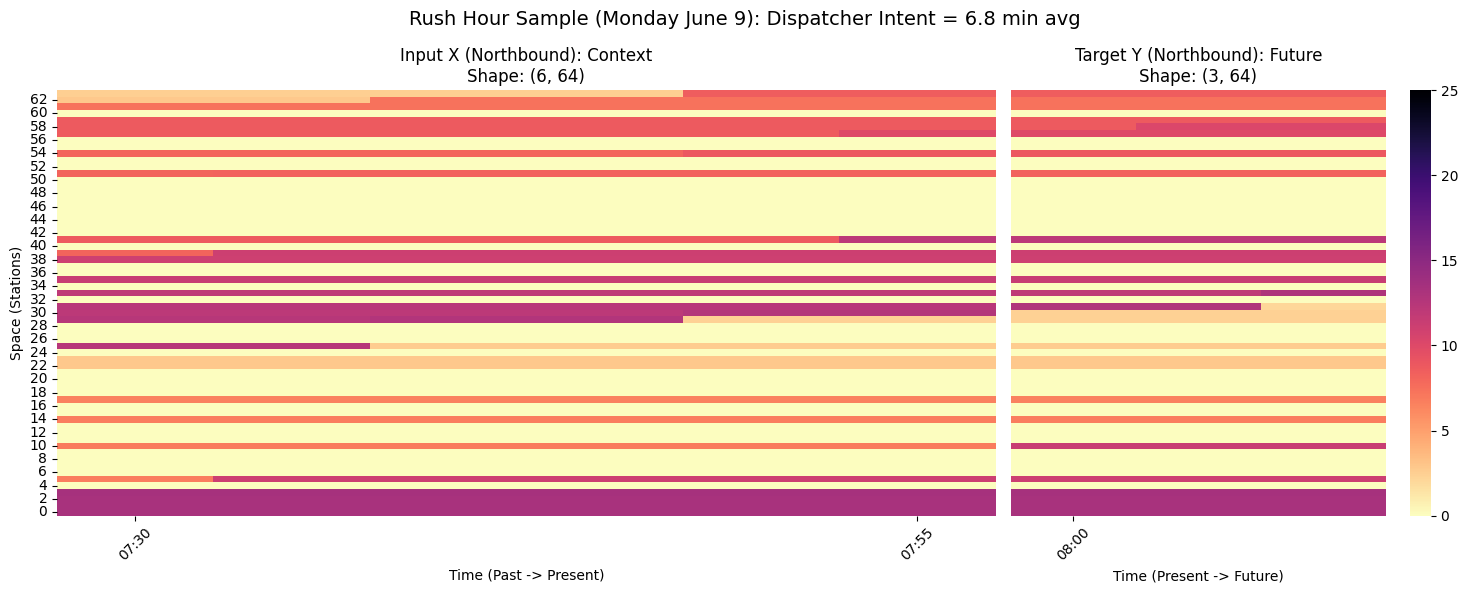

In [9]:
# --- 4. Visualize a Specific Rush Hour Example ---
# Let's look at Monday Morning Rush Hour (June 9th, 8:00 AM)
# This should show stronger "streams" of traffic than a random sample.

target_time = pd.Timestamp("2025-06-09 08:00:00")
start_time = pd.Timestamp(GLOBAL_START_TIME)

# Calculate the index in the original matrix
time_diff = target_time - start_time
matrix_idx = int(time_diff.total_seconds() / 60 / TIME_BIN_SIZE_MIN)

# Adjust for the sliding window offset (X_sample starts after 'lookback_bins')
# X_sample[0] corresponds to matrix index 'L_BINS'
sample_idx = matrix_idx - L_BINS

print(f"Target Time: {target_time}")
print(f"Matrix Index: {matrix_idx}")
print(f"Sample Index: {sample_idx}")

# Extract the components (Selecting Northbound: Direction=0)
x_example = X_sample[sample_idx, :, :, 0, 0]  # Shape: (L, Space)
t_example = T_sample[sample_idx, :, 0, 0]     # Shape: (F,)
y_example = Y_sample[sample_idx, :, :, 0, 0]  # Shape: (F, Space)

# --- Generate Time Labels ---
# X Labels: Past 30 mins
x_time_labels = pd.date_range(end=target_time, periods=L_BINS+1, freq=f'{TIME_BIN_SIZE_MIN}min')[:-1]
x_labels = [t.strftime('%H:%M') for t in x_time_labels]

# Y Labels: Next 15 mins
y_time_labels = pd.date_range(start=target_time, periods=F_BINS, freq=f'{TIME_BIN_SIZE_MIN}min')
y_labels = [t.strftime('%H:%M') for t in y_time_labels]

# Create a combined plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [2, 1]})

# Plot 1: The Context (X)
# NOTE: We use 'nearest' interpolation to avoid blurring the 1-minute pixels
sns.heatmap(x_example.T, ax=axes[0], cmap="magma_r", vmin=0, vmax=25, cbar=False)
axes[0].set_title(f"Input X (Northbound): Context\nShape: {x_example.shape}")
axes[0].set_xlabel("Time (Past -> Present)")
axes[0].set_ylabel("Space (Stations)")

# Reduce label density for readability (show every 5th label)
axes[0].set_xticks(np.arange(0, len(x_labels), 5) + 0.5)
axes[0].set_xticklabels(x_labels[::5], rotation=45)
axes[0].invert_yaxis()

# Plot 2: The Target (Y)
sns.heatmap(y_example.T, ax=axes[1], cmap="magma_r", vmin=0, vmax=25)
axes[1].set_title(f"Target Y (Northbound): Future\nShape: {y_example.shape}")
axes[1].set_xlabel("Time (Present -> Future)")
axes[1].set_yticks([])

# Reduce label density for readability (show every 5th label)
axes[1].set_xticks(np.arange(0, len(y_labels), 5) + 0.5)
axes[1].set_xticklabels(y_labels[::5], rotation=45)
axes[1].invert_yaxis()

plt.suptitle(f"Rush Hour Sample (Monday June 9): Dispatcher Intent = {t_example.mean():.1f} min avg", fontsize=14)
plt.tight_layout()
plt.show()

## 4. Deep Dive: Understanding the Sliding Window Logic

To ensure we trust our model inputs, let's verify the temporal alignment of our tensors $(X, T, Y)$.

The `create_dataset` function uses a sliding window approach where index `i` represents the **"Present"** (the moment we make a prediction).

*   **Input X (Context):** `matrix[i-L : i]`
    *   Captures the *past* `L` steps.
    *   Range: $[t_{current} - 60\text{min}, t_{current})$
*   **Input T (Intent):** `schedule[i : i+F]`
    *   Captures the *future* `F` steps of the schedule.
    *   Range: $[t_{current}, t_{current} + 30\text{min})$
*   **Target Y (Ground Truth):** `matrix[i : i+F]`
    *   Captures the *future* `F` steps of the actual headway.
    *   Range: $[t_{current}, t_{current} + 30\text{min})$

Let's programmatically verify this alignment using the timestamps.

In [10]:
# --- Verification of Temporal Alignment ---

# Re-calculate the index for our specific example (Monday 8:00 AM)
# We used 'sample_idx' in the previous cell.

# 1. Get the exact timestamps from the original dataframe for this window
# The 'sample_idx' in X_sample corresponds to 'matrix_idx' in the original data
# because X_sample[0] was created when i = L_BINS.
# So, X_sample[k] corresponds to i = L_BINS + k.

current_i = L_BINS + sample_idx

# Define the ranges based on the logic
x_range_indices = range(current_i - L_BINS, current_i)
y_range_indices = range(current_i, current_i + F_BINS)

print(f"--- Verification for Sample Index {sample_idx} ---")
print(f"Prediction Time (t=0): {da.time.values[current_i]}")

print("\n1. Input X (Context) Time Range:")
print(f"   Start: {da.time.values[x_range_indices[0]]}")
print(f"   End:   {da.time.values[x_range_indices[-1]]}")
print(f"   (This should be strictly BEFORE prediction time)")

print("\n2. Target Y (Future) Time Range:")
print(f"   Start: {da.time.values[y_range_indices[0]]}")
print(f"   End:   {da.time.values[y_range_indices[-1]]}")
print(f"   (This should START AT prediction time)")

# Check for overlap
assert x_range_indices[-1] < y_range_indices[0], "CRITICAL ERROR: Data Leakage! X and Y overlap."
print("\n✅ SUCCESS: No overlap between Input X and Target Y.")

--- Verification for Sample Index 954 ---
Prediction Time (t=0): 2025-06-09T08:00:00.000000000

1. Input X (Context) Time Range:
   Start: 2025-06-09T07:30:00.000000000
   End:   2025-06-09T07:55:00.000000000
   (This should be strictly BEFORE prediction time)

2. Target Y (Future) Time Range:
   Start: 2025-06-09T08:00:00.000000000
   End:   2025-06-09T08:10:00.000000000
   (This should START AT prediction time)

✅ SUCCESS: No overlap between Input X and Target Y.


## 5. Data Quality & Safety Checks

Before moving to model training, we perform final sanity checks to ensure the tensors are clean and valid.

In [11]:
# --- Safety Checks ---

print("--- 1. NaN Checks ---")
print(f"NaNs in X: {np.isnan(X_sample).sum()}")
print(f"NaNs in T: {np.isnan(T_sample).sum()}")
print(f"NaNs in Y: {np.isnan(Y_sample).sum()}")

# Assert no NaNs
assert not np.isnan(X_sample).any(), "Error: NaNs found in Input X"
assert not np.isnan(T_sample).any(), "Error: NaNs found in Input T"
assert not np.isnan(Y_sample).any(), "Error: NaNs found in Target Y"
print("✅ No Missing Values found.")

print("\n--- 2. Value Range Checks ---")
print(f"Headway Range (X, Y): {X_sample.min():.2f} min to {X_sample.max():.2f} min")
print(f"Schedule Range (T):   {T_sample.min():.2f} min to {T_sample.max():.2f} min")

# Check for negative headways (impossible)
assert X_sample.min() >= 0, "Error: Negative headways found in X"
assert Y_sample.min() >= 0, "Error: Negative headways found in Y"
print("✅ Values are within valid non-negative range.")

print("\n--- 3. Shape Consistency ---")
# Ensure T matches Y in temporal dimension
assert T_sample.shape[1] == Y_sample.shape[1], "Error: Schedule (T) and Target (Y) have different time horizons."
print(f"Forecast Horizon matches: {T_sample.shape[1]} steps ({T_sample.shape[1] * TIME_BIN_SIZE_MIN} mins)")

print("\n--- 4. Schedule vs Reality Sanity Check ---")
# The schedule (T) should be somewhat correlated with reality (Y), 
# but reality will have higher variance.
avg_schedule = T_sample.mean()
avg_reality = Y_sample.mean()
print(f"Average Scheduled Headway: {avg_schedule:.2f} min")
print(f"Average Actual Headway:    {avg_reality:.2f} min")

diff = abs(avg_schedule - avg_reality)
print(f"Difference: {diff:.2f} min")
if diff < 5:
    print("✅ Schedule and Reality are reasonably aligned (on average).")
else:
    print("⚠️ Warning: Large discrepancy between Schedule and Reality.")

--- 1. NaN Checks ---
NaNs in X: 0
NaNs in T: 0
NaNs in Y: 0
✅ No Missing Values found.

--- 2. Value Range Checks ---
Headway Range (X, Y): 0.00 min to 20.00 min
Schedule Range (T):   0.00 min to 24.00 min
✅ Values are within valid non-negative range.

--- 3. Shape Consistency ---
Forecast Horizon matches: 3 steps (15 mins)

--- 4. Schedule vs Reality Sanity Check ---
Average Scheduled Headway: 11.77 min
Average Actual Headway:    4.29 min
Difference: 7.48 min
⚠️ Warning: Large discrepancy between Schedule and Reality.
